# Entorhinal Analysis Code

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def entropy(x):
    _, counts = np.unique(x, return_counts=True, axis=0)
    p_x = counts / x.shape[0]
    return -np.sum(p_x * np.log2(p_x))

def conditional_entropy(x, y):
    """H(X|Y) = H(X, Y) - H(Y)"""
    H_xy = entropy(np.concatenate([x, y], axis=1))
    H_y = entropy(y)
    return H_xy - H_y

def compute_ncmi(s, z, n_neighbors=3):
    """
    Normalized conditional mutual information between sources s and latents z.
    The [i, j] element is the conditional mutual information between the i-th source and the j-th latent 
    given the rest of the sources, normalized by the conditional entropy of the i-th source given the rest
    of the sources.
    I(z_j; s_i | s_{-i}) = I(z_j; s_i, s_{-i}) - I(z_j; s_{-i}) = I(z_j; s) - I(z_j; s_{-i})
    NCMI[i, j] = I(z_j; s_i | s_{-i}) / H(s_i | s_{-i})
    """
    
    ds = s.shape[1]
    dz = z.shape[1]
    
    I_z_j_and_s_joint = np.empty(shape=(dz,))
    s_joint = LabelEncoder().fit_transform([str(s_sample) for s_sample in s])
    for j in range(dz):
        I_z_j_and_s_joint[j] = mutual_info_classif(z[:, j].reshape(-1, 1), s_joint, n_neighbors=n_neighbors).squeeze()
    
    ncmi = np.empty(shape=(ds, dz))
    for i in range(ds):
        s_rest = s[:, np.arange(ds) != i]
        s_rest_str = LabelEncoder().fit_transform([str(s_sample) for s_sample in s_rest])
        for j in range(dz):
            I_z_j_and_s_rest = mutual_info_classif(z[:, j].reshape(-1, 1), s_rest_str, n_neighbors=n_neighbors).squeeze()
            ncmi[i, j] = I_z_j_and_s_joint[j] - I_z_j_and_s_rest
        H_s_i_given_s_rest = conditional_entropy(s[:, i].reshape(-1, 1), s_rest)
        ncmi[i, :] /= H_s_i_given_s_rest
    return ncmi

def compute_cinfomec(s, z):
    """
    Compute CInfoM, CInfoC, and InfoE between discrete sources s and continuous latents z.
    s: np.ndarray, shape=(n_samples, n_sources)
    z: np.ndarray, shape=(n_samples, n_latents)
    
    Inactive latents are heuristically identified by their range being less than a proportion of the range of the most active latent. Inactive latents are ignored in the computation of CInfoM and CInfoC.
    """
    ncmi = compute_ncmi(s, z)
    ncmi[ncmi < 0] = 0
    
    z_ranges = np.max(z, axis=0) - np.min(z, axis=0)
    max_z_range = np.max(z_ranges)
    z_active = z_ranges > 0.1 * max_z_range
    
    ds = s.shape[1]
    ncmi_active = ncmi[:, z_active]
    dz_active = np.sum(z_active)
    if dz_active == 0:
        return {
            'CInfoM': 0,
            'CInfoC': 0,
            # 'InfoE': 0,
            'NCMI': ncmi,
            'z_active': z_active
        }
    cinfom = (np.mean(np.max(ncmi_active, axis=0) / np.sum(ncmi_active, axis=0)) - 1 / ds) / (
                1 - 1 / ds)
    cinfoc = (np.mean(np.max(ncmi_active, axis=1) / np.sum(ncmi_active, axis=1)) - 1 / dz_active) / (
                1 - 1 / dz_active)
    # infoe = infomec.compute_infoe(s, z, 'discrete', 'continuous')
    return {
        'CInfoM': cinfom,
        'CInfoC': cinfoc,
        # 'InfoE': infoe,
        'NCMI': ncmi,
        'z_active': z_active
    }

In [2]:
params_best = np.load('./data/PI_Learnt_Reps/random_1.npy', allow_pickle = True)[()]

Text(0.5, 0.98, 'Action Maps in 64 Rooms')

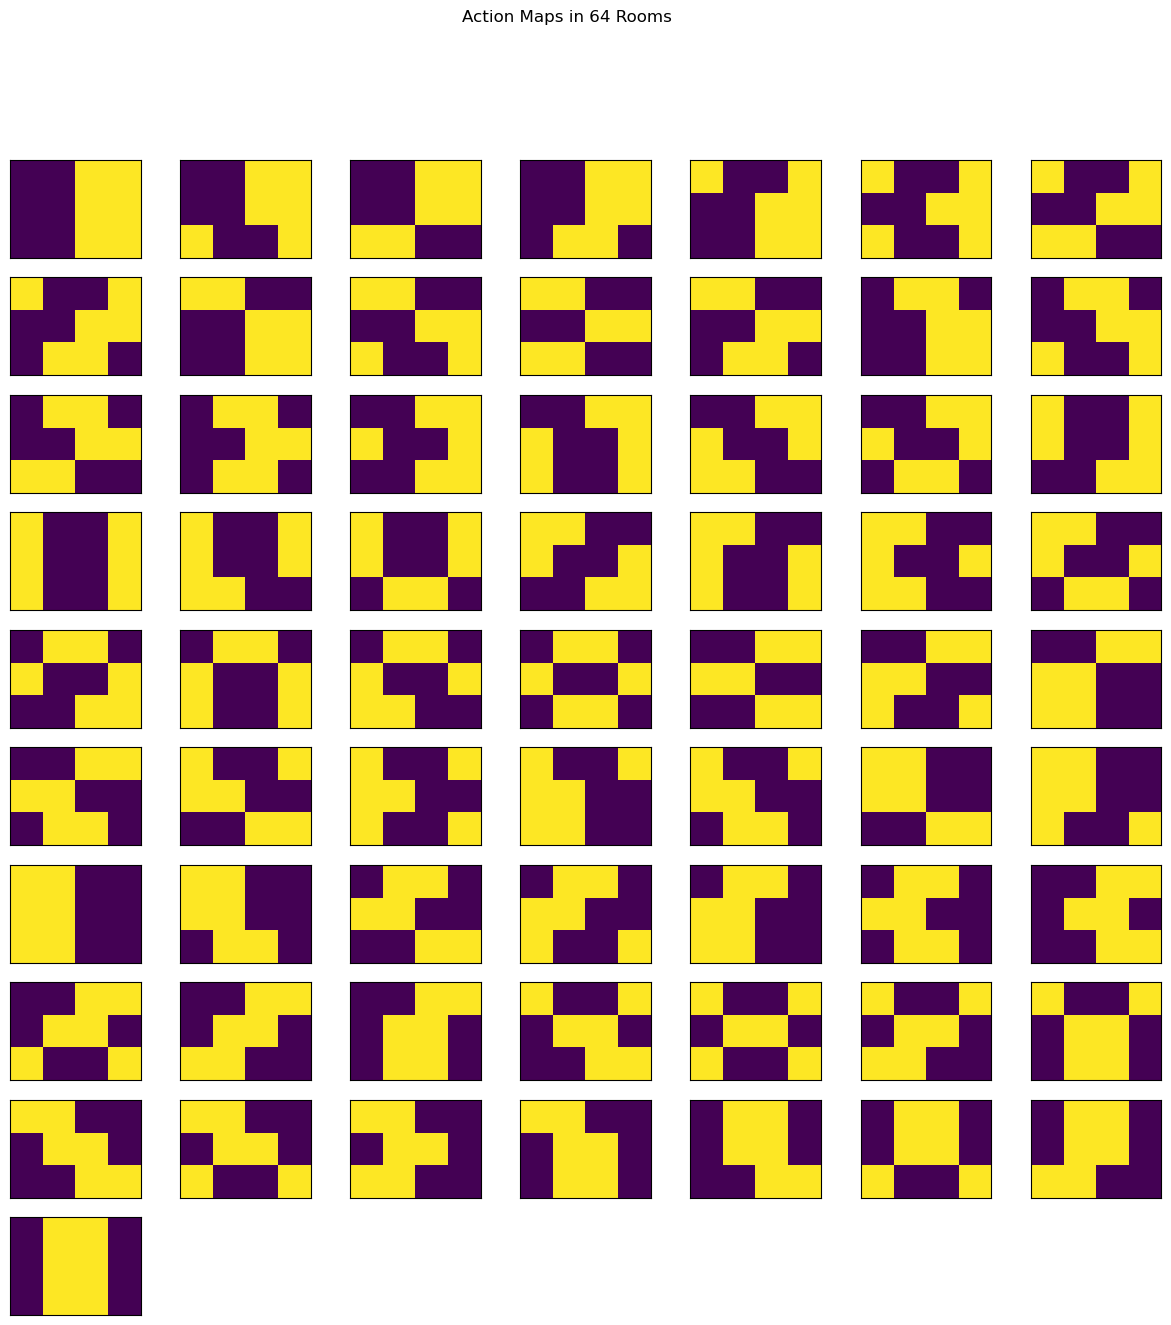

In [12]:
# Set up training data

L = 3 # Size of grid world length, for ease use even number
D_Tot = (L)**num_objects # Number of conditions

labels = np.zeros([num_objects, L, D_Tot])
sampling_roles = np.zeros([D_Tot])
object_positions = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
object_positions_flat = np.stack([np.ndarray.flatten(object_positions[i]) for i in range(num_objects)])
for object_id, this_object_position in enumerate(object_positions):
    for room in range(D_Tot):
        object_position = object_positions_flat[object_id,room] -0.5
        for l in range(L):
            distance = np.abs(l-object_position)
            if np.abs(l - object_position - L) < distance:
                labels[object_id, l, room] = 1
            elif np.abs(l - object_position + L) < distance:
                labels[object_id, l, room] = 0
            else:
                labels[object_id, l, room] = l-object_position < 0


for room in range(D_Tot):
    if np.logical_and(np.mod(object_positions_flat[0,room] + 1, L) == object_positions_flat[1,room], np.mod(object_positions_flat[1,room] + 1, L) == object_positions_flat[2,room]):
        sampling_roles[room] = 1
        
plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D_Tot/plot_rows)+1
for room in range(D_Tot):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(labels[:,:,room])
    plt.xticks([])
    plt.clim([0,1])
    plt.yticks([])

plt.suptitle(f'Action Maps in {D_Tot} Rooms')

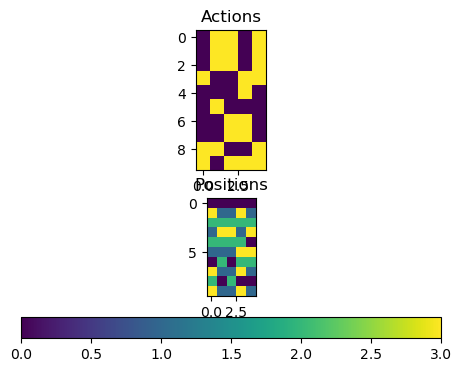

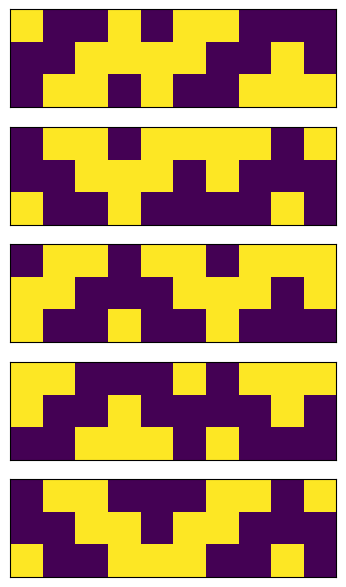

In [13]:
# Create random data to feed the network
T = 10 # Length of each trajectory
D = 5 # How many rooms to sample

def generate_trajectories_random(T, D, L, sampling_roles):
    # Set up actions, have to explore the room for the first L timesteps, then random
    actions = np.zeros([T, D])
    actions[0,:] = np.random.choice(2, [1,D])
    actions[1:L-1,:] = actions[0,:][None,:]
    actions[L-1:,:] = np.random.choice(2, [T-L+1,D])
    actions = actions.astype(int)
    
    # Given actions, compute the positions
    positions = np.zeros([T, D])
    for t in range(1, T):
        positions[t,:] = np.mod(positions[t-1,:] + 2*actions[t-1,:]-1, L) # This is for periodic
    positions = positions.astype(int)

    rooms = np.zeros([D])
    for room in range(D):
        if np.random.sample(1) > 0.5:
            rooms[room] = np.random.choice(np.where(sampling_roles == 1)[0])
        else:
            rooms[room] = np.random.choice(np.where(sampling_roles == 0)[0])
    rooms = rooms.astype(int)
    
    network_signals = np.zeros([num_objects,T,D])
    for d in range(D):
        for t in range(T):
            for input_dim in range(num_objects):
                network_signals[input_dim,t,d] = labels[input_dim,positions[t,d],rooms[d]]
        
    return actions, positions, network_signals, rooms

actions, positions, network_signals, rooms = generate_trajectories_random(T, D, L, sampling_roles)

plt.figure(figsize = (20, 4))
plt.subplot(2,1,1)
plt.imshow(actions)
plt.title('Actions')
plt.xticks()
plt.yticks()

plt.subplot(2,1,2)
plt.imshow(positions)
plt.title('Positions')
plt.colorbar(orientation="horizontal")
plt.xticks()
plt.yticks()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])

In [14]:
def generate_rep_non_jit(params, inputs, actions):
    # Inputs: input_dim x traj length x rooms
    # Actions: traj length x rooms
    # Rep: neurons x traj length x rooms
    T_here = inputs.shape[1]
    D_use = inputs.shape[2]
    g = jnp.zeros([N, T_here, D_use])
    g = g.at[:,0,:].set(params['I'][:,:-1]@inputs[:,0,:] + params['I'][:,-1][:,None])
    
    for t in range(1,L):
        input_current = params['I'][:,:-1]@inputs[:,t,:] + params['I'][:,-1][:,None]
        recurrent_input = jnp.einsum('ijk,ki->ji', params['W'][actions[t-1],:,:-1],g[:,t-1,:]) + params['W'][actions[t-1],:,-1].T
        g = g.at[:,t,:].set(input_current + recurrent_input)

    for t in range(L,T_here):
        g = g.at[:,t,:].set(jnp.einsum('ijk,ki->ji', params['W'][actions[t-1],:,:-1],g[:,t-1,:]) + params['W'][actions[t-1],:,-1].T)

    return g

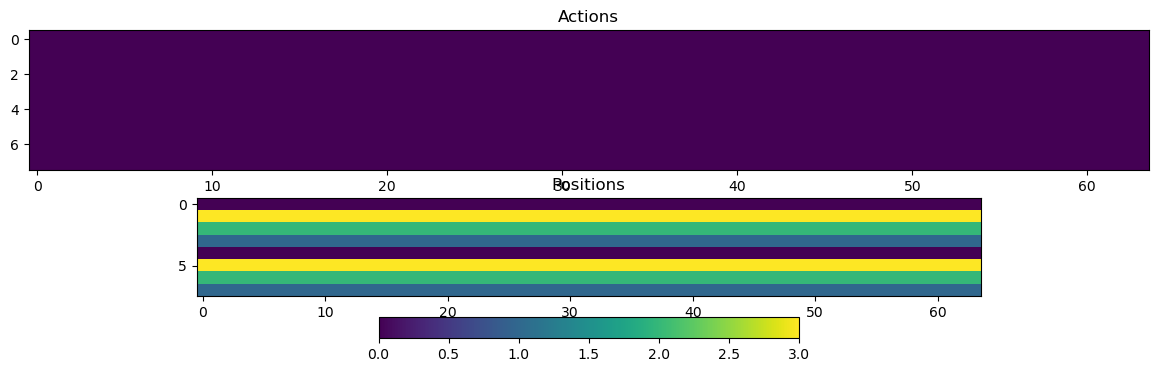

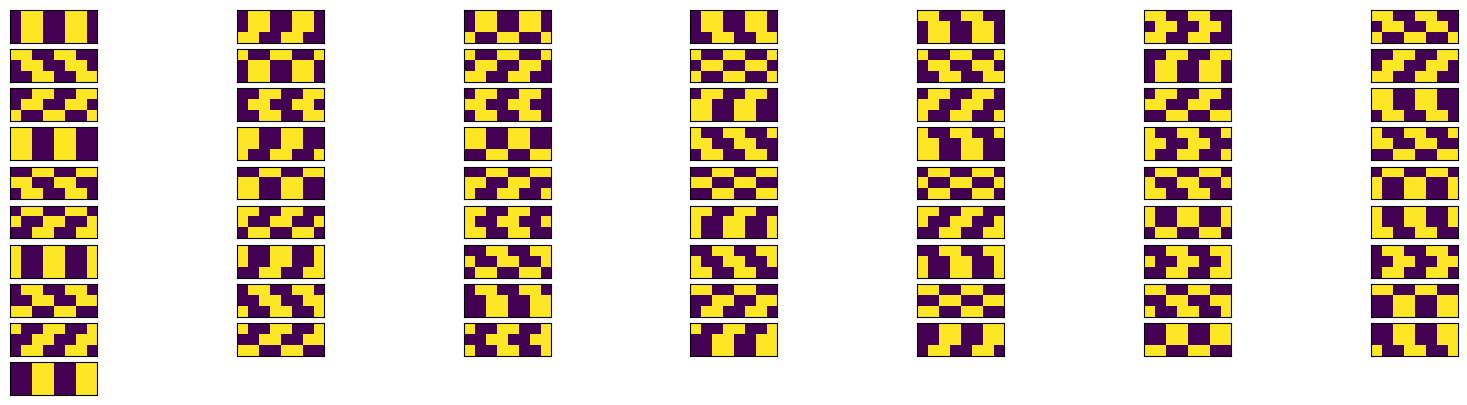

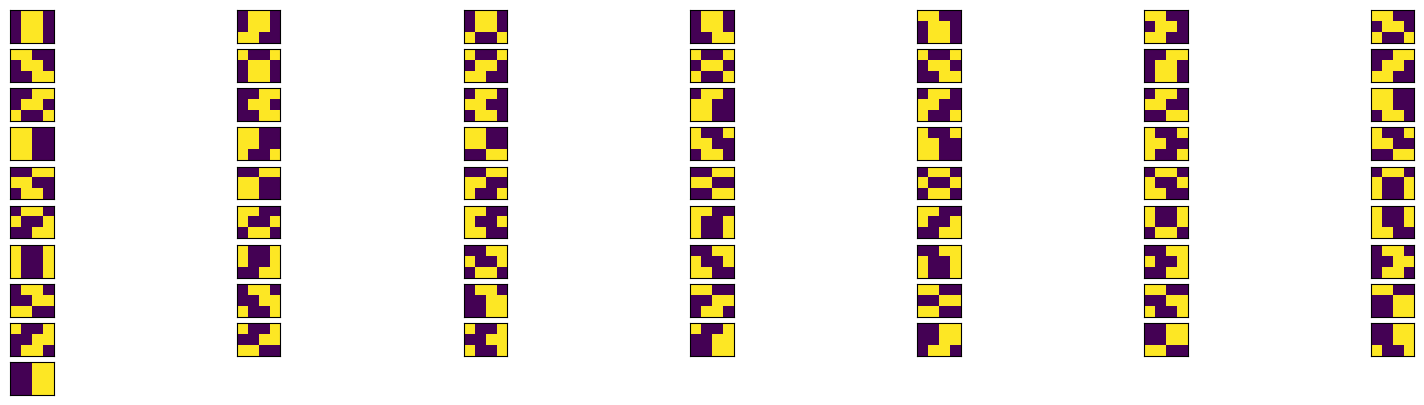

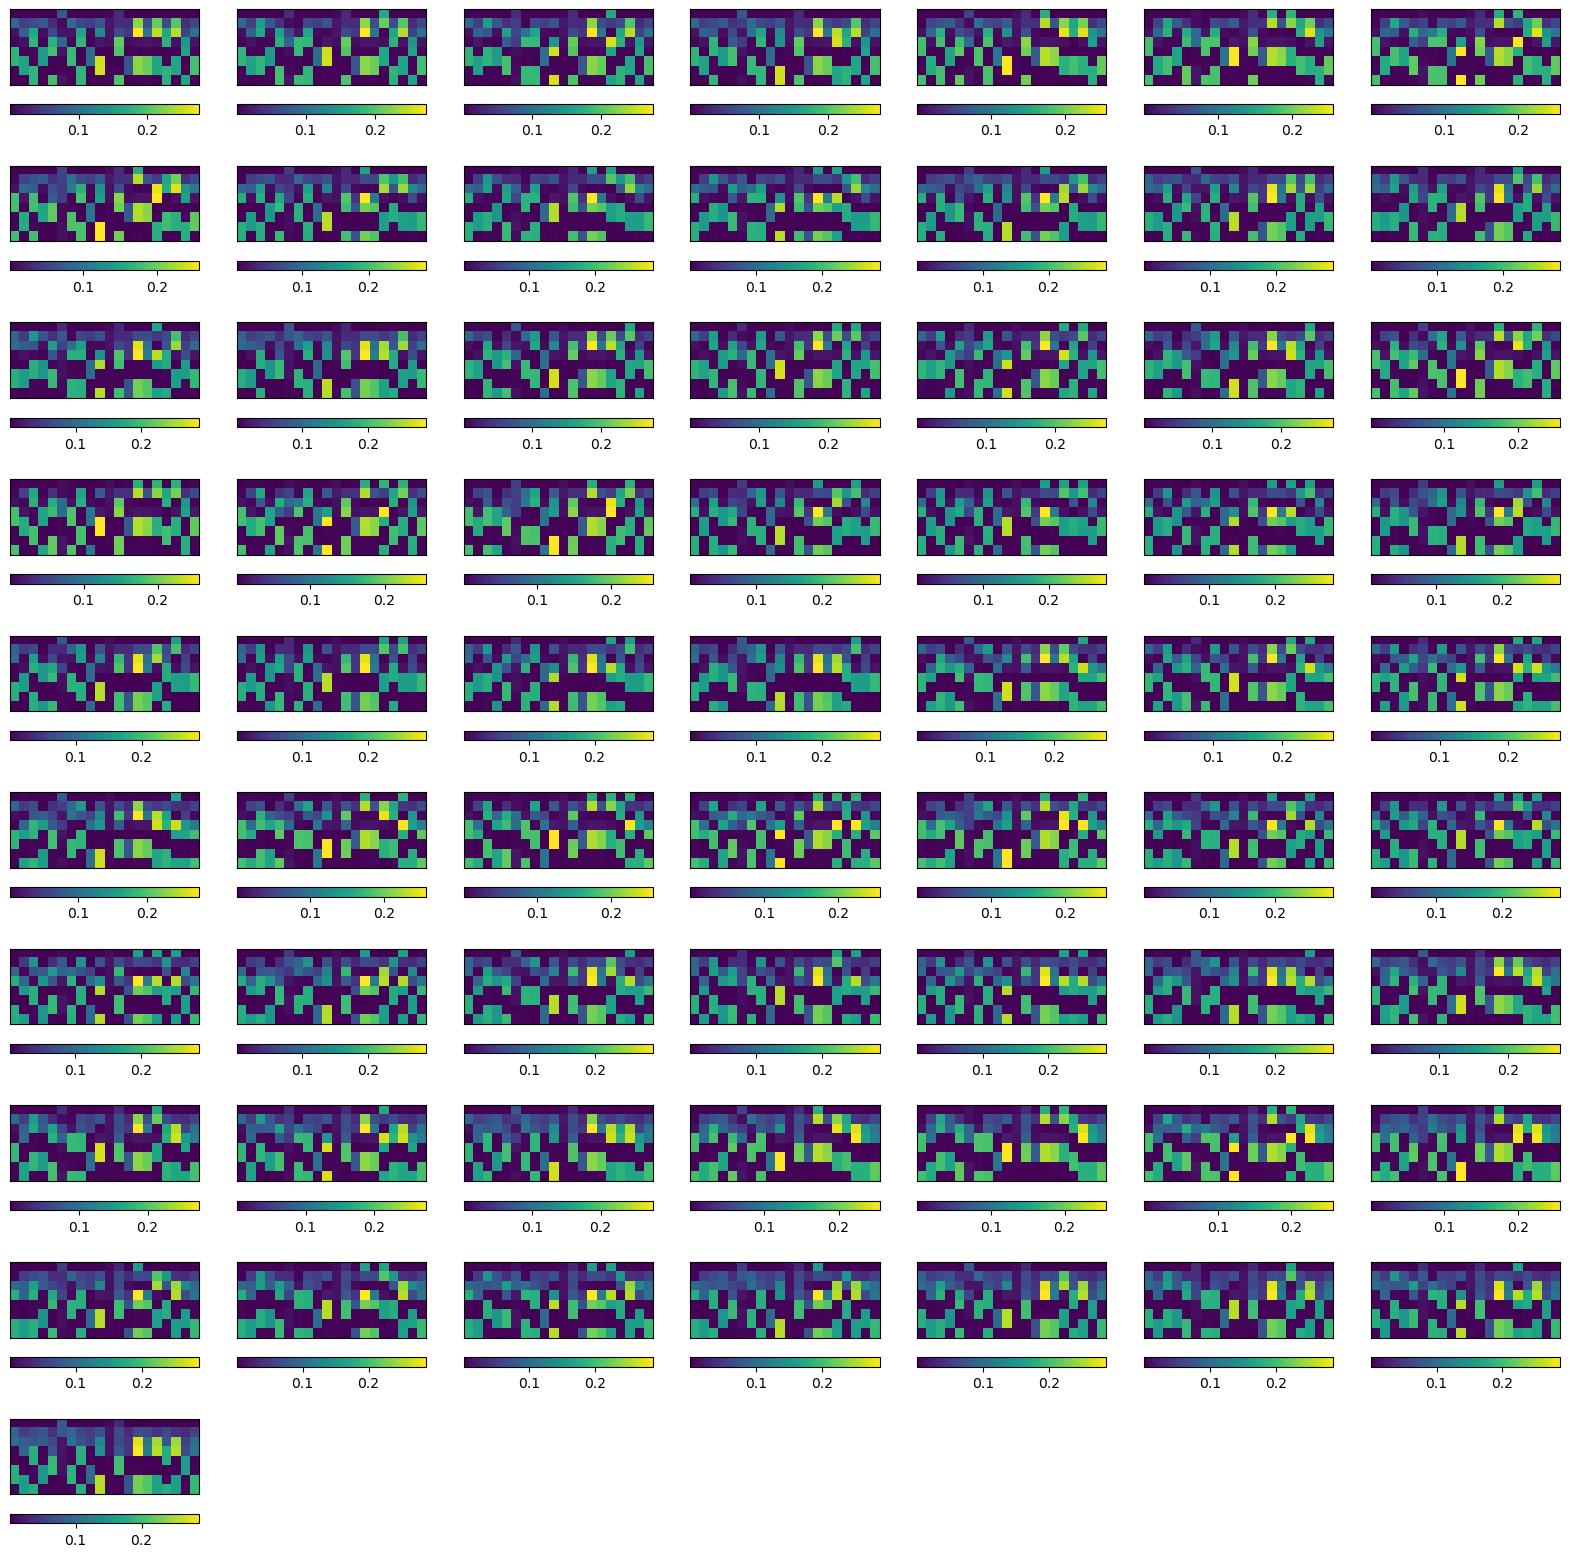

In [119]:
# First we test it on the data it is trained on
T_here = 2*L
D_here = D_Tot

def generate_trajectories_forward(T, D, L, inputs):
    # This time all the actions just go in one direction
    actions = np.zeros([T, D])
    actions = actions.astype(int)
    
    # Given actions, compute the positions
    positions = np.zeros([T, D])
    for t in range(1, T):
        positions[t,:] = np.mod(positions[t-1,:] + 2*actions[t-1,:]-1, L)
    positions = positions.astype(int)

    network_signals = np.zeros([num_objects,T,D])
    for d in range(D):
        for t in range(T):
            for input_dim in range(num_objects):
                network_signals[input_dim,t,d] = inputs[input_dim,positions[t,d],d]
        
    return actions, positions, network_signals
    
    
actions_forward, positions_forward, network_signals_forward = generate_trajectories_forward(T_here, D_here, L, labels)

# Plot these trajectories
plt.figure(figsize = (20, 4))
plt.subplot(2,1,1)
plt.imshow(actions_forward)
plt.title('Actions')
plt.xticks()
plt.yticks()

plt.subplot(2,1,2)
plt.imshow(positions_forward)
plt.title('Positions')
plt.colorbar(orientation="horizontal")
plt.xticks()
plt.yticks()

plt.figure(figsize = (20,5))
plot_rows = 10
plot_cols = int(D_here/plot_rows)+1
for room in range(D_here):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals_forward[:,:,room])
    plt.xticks([])
    plt.yticks([])

# Then generate data
g = generate_rep_non_jit(params_best, network_signals_forward, actions_forward)
preds = jnp.einsum('ij, jkl -> ikl', params_best["R"][:,:-1], g) + params_best["R"][:,-1][:,None,None]

plt.figure(figsize = (20, 5))
for room in range(D_here):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(preds[:,L:,room])
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize = (20, 20))
plot_rows = 10
for room in range(D_here):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(g[:,:,room].T)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation='horizontal')

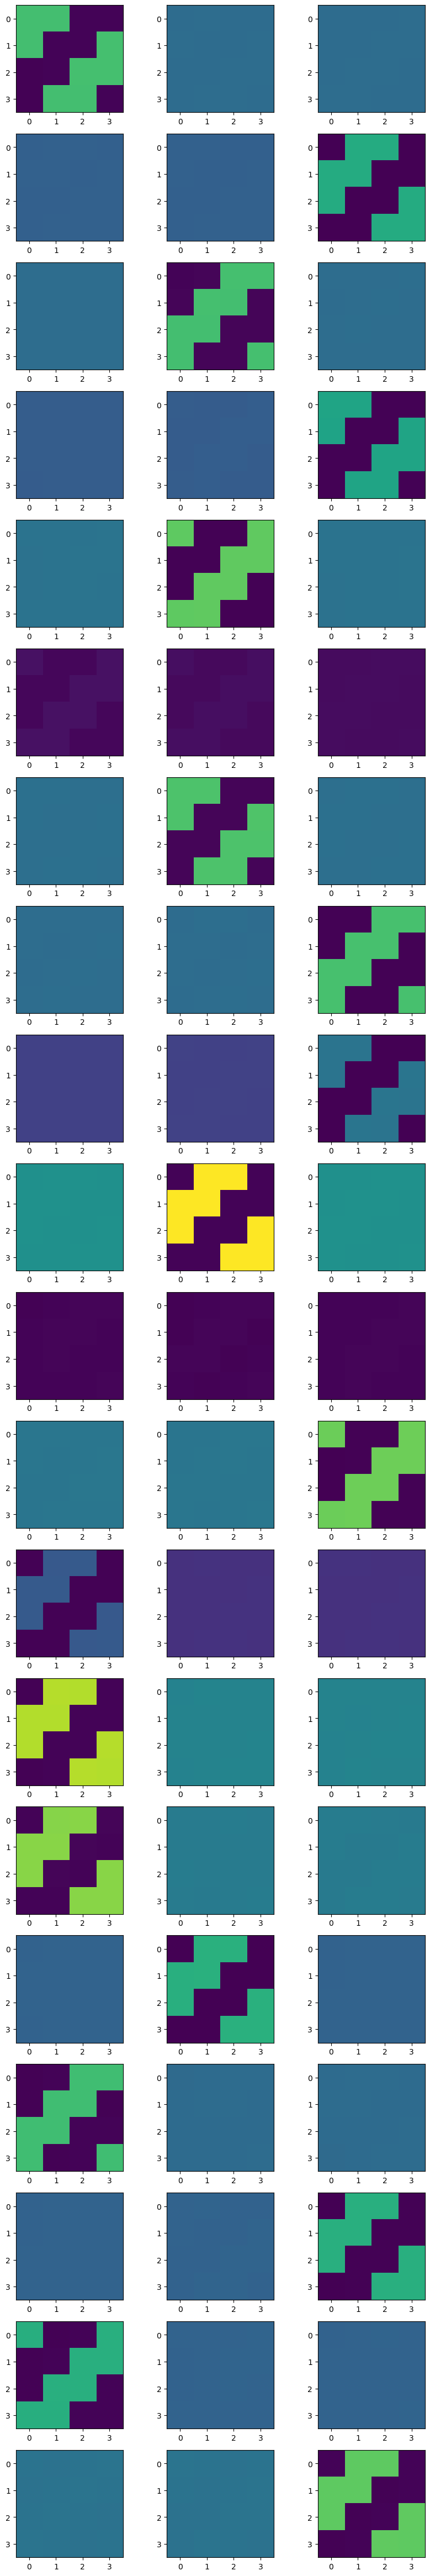

In [120]:
g_cut = g[:,L:,:]
g_tuning = np.zeros([N, num_objects, L,L])
for object in range(num_objects):
    this_object_positions = np.ndarray.flatten(object_positions[object], 'F')
    for l in range(L):
        g_tuning[:,object,l,:] = np.mean(g_cut[:,:,this_object_positions == l],axis = 2)

neurons = np.arange(N)
num_neurons= len(neurons)

plt.figure(figsize = (10, 3*num_neurons))
min_color = np.min(g_tuning)
max_color = np.max(g_tuning)
for neuron_ind, neuron in enumerate(neurons):
    for i in range(3):
        plt.subplot(num_neurons,3,i+1+3*neuron_ind)
        plt.imshow(g_tuning[neuron,i,:,:])
        plt.clim([min_color, max_color])

In [121]:
g_tuning.shape

(20, 3, 4, 4)

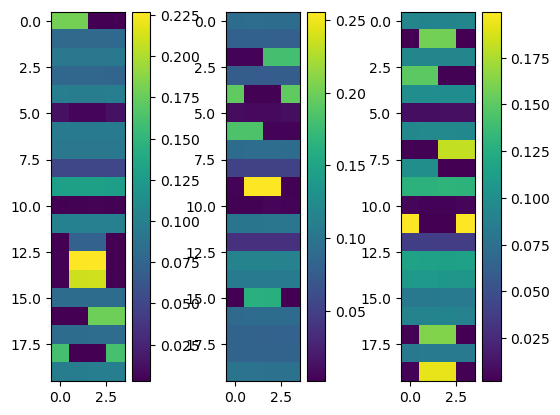

In [122]:
g_tuning_avg = np.zeros([N, num_objects, L])
for neuron in range(N):
    for object in range(num_objects):
        tuning = np.zeros([L])
        for l in range(L):
            tuning += g_tuning[neuron, object, np.mod(np.arange(L) - l, L), l]
        g_tuning_avg[neuron,object,:] = tuning/L

for object in range(num_objects):
    plt.subplot(1, 3, object+1)
    plt.imshow(g_tuning_avg[:,object,:])
    plt.colorbar()

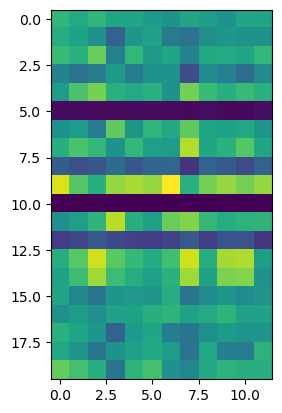

In [283]:
g_cut = g[:,L:,:]
g_tuning = np.zeros([N, num_objects, L])
animal_positions = np.arange(L)
for object in range(num_objects):
    this_object_positions = np.ndarray.flatten(object_positions[object], 'F')
    relative_location = animal_positions[:,None] - this_object_positions[None,:]
    for l in range(L):
        this_offset_indices = np.where(relative_location == l)
        g_tuning[:,object,l] = np.mean(g_cut[:,this_offset_indices[0],this_offset_indices[1]], axis = 1)

neurons = np.arange(N)
num_neurons= len(neurons)

plt.imshow(np.reshape(g_tuning, [N, num_objects*L]))

In [284]:
g.shape

(20, 10, 1000)

In [285]:
# Try to use the position relative to each object code, on something that definitely works....
g_know = g[:,L:,:]
T_use = g_know.shape[1]
D_use = g_know.shape[2]

positions_relative_to_each_object = np.zeros([num_objects, T_use, D_use])
for d in range(D_use):
    room = d
    position_this_room = positions_forward[L:,d]
    object_positions_this_room = object_positions_flat[:,room]

    for t_ind, position in enumerate(position_this_room):
        for object in range(num_objects):
            positions_relative_to_each_object[object, t_ind, d] = position - object_positions_this_room[object]
            if positions_relative_to_each_object[object, t_ind, d] > 3:
                positions_relative_to_each_object[object, t_ind, d] -= L
            elif positions_relative_to_each_object[object, t_ind, d] < 0:
                positions_relative_to_each_object[object, t_ind, d] += L

IndexError: index 64 is out of bounds for axis 1 with size 64

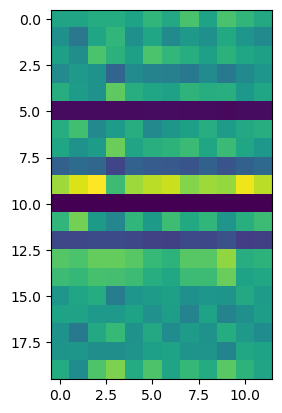

In [286]:
g_tuning = np.zeros([N, num_objects, L])
for object in range(num_objects):
    for l in range(L):
        indices = np.where(positions_relative_to_each_object[object,:,:] == l)
        g_tuning[:,object,l] = np.mean(g_know[:,indices[0], indices[1]], axis = 1)

plt.imshow(np.reshape(g_tuning, [N, num_objects*L]))

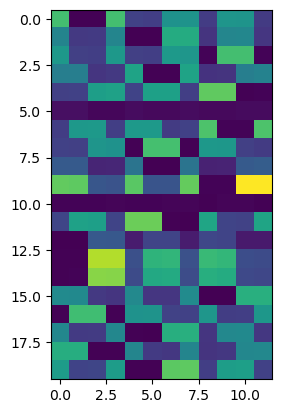

In [287]:
D_sample = 1000
actions, positions, network_signals, rooms = generate_trajectories_random(T, D_sample, L, sampling_roles)
g = generate_rep_non_jit(params_best, network_signals, actions)

g_know = g[:,L:,:]
T_use = g_know.shape[1]

# Try to use the position relative to each object code, on something that definitely works....
g_know = g[:,L:,:]
T_use = g_know.shape[1]
D_use = g_know.shape[2]

positions_relative_to_each_object = np.zeros([num_objects, T_use, D_use])
for d in range(D_use):
    room = rooms[d]
    position_this_room = positions[L:,d]
    object_positions_this_room = object_positions_flat[:,room]

    for t_ind, position in enumerate(position_this_room):
        for object in range(num_objects):
            positions_relative_to_each_object[object, t_ind, d] = position - object_positions_this_room[object]
            if positions_relative_to_each_object[object, t_ind, d] > 3:
                positions_relative_to_each_object[object, t_ind, d] -= L
            elif positions_relative_to_each_object[object, t_ind, d] < 0:
                positions_relative_to_each_object[object, t_ind, d] += L

g_tuning = np.zeros([N, num_objects, L])
for object in range(num_objects):
    for l in range(L):
        indices = np.where(positions_relative_to_each_object[object,:,:] == l)
        g_tuning[:,object,l] = np.mean(g_know[:,indices[0], indices[1]], axis = 1)

plt.imshow(np.reshape(g_tuning, [N, num_objects*L]))

In [288]:
D_sample = 1000
actions, positions, network_signals, rooms = generate_trajectories_random(T, D_sample, L, sampling_roles)
g = generate_rep_non_jit(params_best, network_signals, actions)

g_know = g[:,L:,:]
T_use = g_know.shape[1]

In [289]:
# Now go through and make the average encoding for each room type
g_avg = np.zeros([N, D_Tot, L])
for room in np.unique(rooms):
    d_indices = np.where(rooms == room)[0]
    positions_within_this_room = positions[L:,d_indices]

    for l in range(L):
        this_l_indices = np.where(positions_within_this_room == l)
        g_avg[:,room,l] = np.mean(g_know[:,this_l_indices[0], d_indices[this_l_indices[1]]], axis = 1)

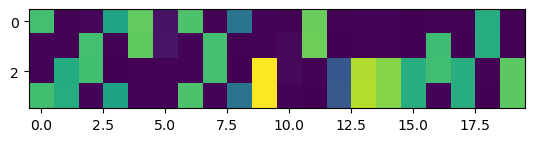

In [290]:
plt.imshow(g_avg[:,0,:].T)

Text(0, 0.5, 'Condition')

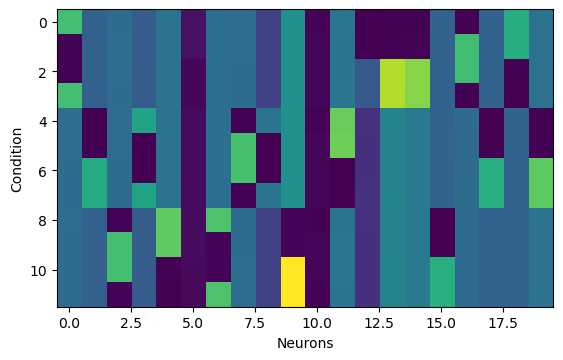

In [291]:
# Try to use the position relative to each object code, on something that definitely works....
positions_relative_to_each_object = np.zeros([num_objects, L, D_Tot])
for d in range(D_Tot):
    object_positions_this_room = object_positions_flat[:,d]

    for position in range(L):
        for object in range(num_objects):
            positions_relative_to_each_object[object, position, d] = position - object_positions_this_room[object]
            if positions_relative_to_each_object[object, position, d] > 3:
                positions_relative_to_each_object[object, position, d] -= L
            elif positions_relative_to_each_object[object, position, d] < 0:
                positions_relative_to_each_object[object, position, d] += L

g_tuning = np.zeros([N, num_objects, L])
for object in range(num_objects):
    for l in range(L):
        indices = np.where(positions_relative_to_each_object[object,:,:] == l)
        g_tuning[:,object,l] = np.mean(g_avg[:,indices[1], indices[0]], axis = 1)

plt.imshow(np.reshape(g_tuning, [N, num_objects*L]).T)
plt.xlabel('Neurons')
plt.ylabel('Condition')

# Drop a Variable -> Mixed Selectivity?

If we only know of two of the three variables, do we misinterpret the remaining ones as mixed selective?

In [292]:
# Generate Data
D_sample = 1000
actions, positions, network_signals, rooms = generate_trajectories_random(T, D_sample, L, sampling_roles)
g = generate_rep_non_jit(params_best, network_signals, actions)

g_know = g[:,L:,:]
T_use = g_know.shape[1]

In [293]:
# Now go through and only distinguish rooms by first and second row (i.e. first and second object position)
all_1_and_2_positions = np.unique(object_positions_flat[:2,:], axis = 1)

# We create the average encoding for all of these situations
g_avg = np.zeros([N, all_1_and_2_positions.shape[1], L])
for room , one_and_two_pos in enumerate(all_1_and_2_positions.T):
    d_indices = np.logical_and(object_positions_flat[0,rooms] == one_and_two_pos[0], object_positions_flat[1,rooms] == one_and_two_pos[1])
    d_indices = np.where(d_indices)[0]
    positions_within_this_room = positions[L:,d_indices]

    for l in range(L):
        this_l_indices = np.where(positions_within_this_room == l)
        g_avg[:,room,l] = np.mean(g_know[:,this_l_indices[0], d_indices[this_l_indices[1]]], axis = 1)

D_Tot_12 = all_1_and_2_positions.shape[1]

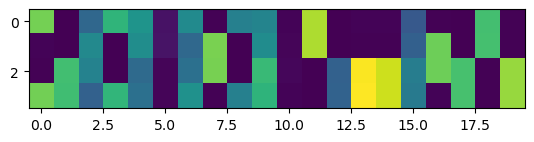

In [294]:
plt.imshow(g_avg[:,0,:].T)

Text(0, 0.5, 'Conditions')

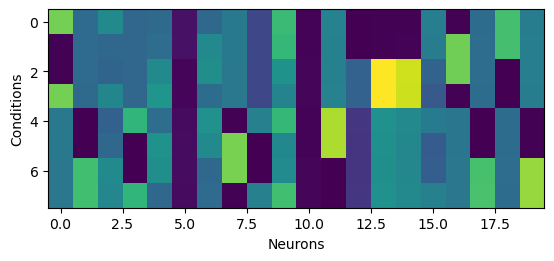

In [296]:
# Try to use the position relative to each object code, on something that definitely works....
positions_relative_to_each_object = np.zeros([2, L, D_Tot_12])
for d in range(D_Tot_12):
    object_positions_this_room = all_1_and_2_positions[:,d]

    for position in range(L):
        for object in range(2):
            positions_relative_to_each_object[object, position, d] = position - object_positions_this_room[object]
            if positions_relative_to_each_object[object, position, d] > 3:
                positions_relative_to_each_object[object, position, d] -= L
            elif positions_relative_to_each_object[object, position, d] < 0:
                positions_relative_to_each_object[object, position, d] += L

g_tuning = np.zeros([N, 2, L])
for object in range(2):
    for l in range(L):
        indices = np.where(positions_relative_to_each_object[object,:,:] == l)
        g_tuning[:,object,l] = np.mean(g_avg[:,indices[1], indices[0]], axis = 1)

plt.imshow(np.reshape(g_tuning, [N, 2*L]).T)
plt.xlabel('Neurons')
plt.ylabel('Conditions')

In [257]:
positions_relative_to_each_object

array([[[0., 0., 0., 0., 3., 3., 3., 3., 2., 2., 2., 2., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 3., 3., 3., 3., 2., 2., 2., 2.],
        [2., 2., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0., 3., 3., 3., 3.],
        [3., 3., 3., 3., 2., 2., 2., 2., 1., 1., 1., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]]])